In [ ]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
from ray import tune

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MAE, MSE, RMSE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [ ]:
from neuralforecast.models import NHITS

In [ ]:
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
df = pd.read_excel('DJIA Realized Volatility (NBEATSx).xlsx',index_col='Date',parse_dates=True)

In [ ]:
n_inputs = [21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7):]

In [29]:
test.head(20)

,ds,unique_id,y,VIX
4093,2016-04-13,Airline1,0.004333,13.840000
4094,2016-04-14,Airline1,0.002793,13.720000
4095,2016-04-15,Airline1,0.002514,13.620000
4096,2016-04-18,Airline1,0.005018,13.350000
4097,2016-04-19,Airline1,0.004235,13.240000
4098,2016-04-20,Airline1,0.005061,13.280000
4099,2016-04-21,Airline1,0.004065,13.950000
4100,2016-04-22,Airline1,0.004629,13.220000
4101,2016-04-25,Airline1,0.006667,14.080000
4102,2016-04-26,Airline1,0.004022,13.960000


In [ ]:
dataset, *_ = TimeSeriesDataset.from_df(df = train)

In [ ]:
dataset2, *_ = TimeSeriesDataset.from_df(df = test)

In [ ]:
model = NBEATSx(h=1, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=-1,
                random_seed=0
                )
model.fit(dataset=dataset)
dataset2 = dataset.update_dataset(dataset, test)
model.set_test_size(20)
y_hat = model.predict(dataset=dataset2)


INFO:lightning_fabric.utilities.seed:Global seed set to 0


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
y_hat = model.predict(dataset=dataset2)

Predicting: 0it [00:00, ?it/s]

In [ ]:
y_hat.shape

(20, 3)

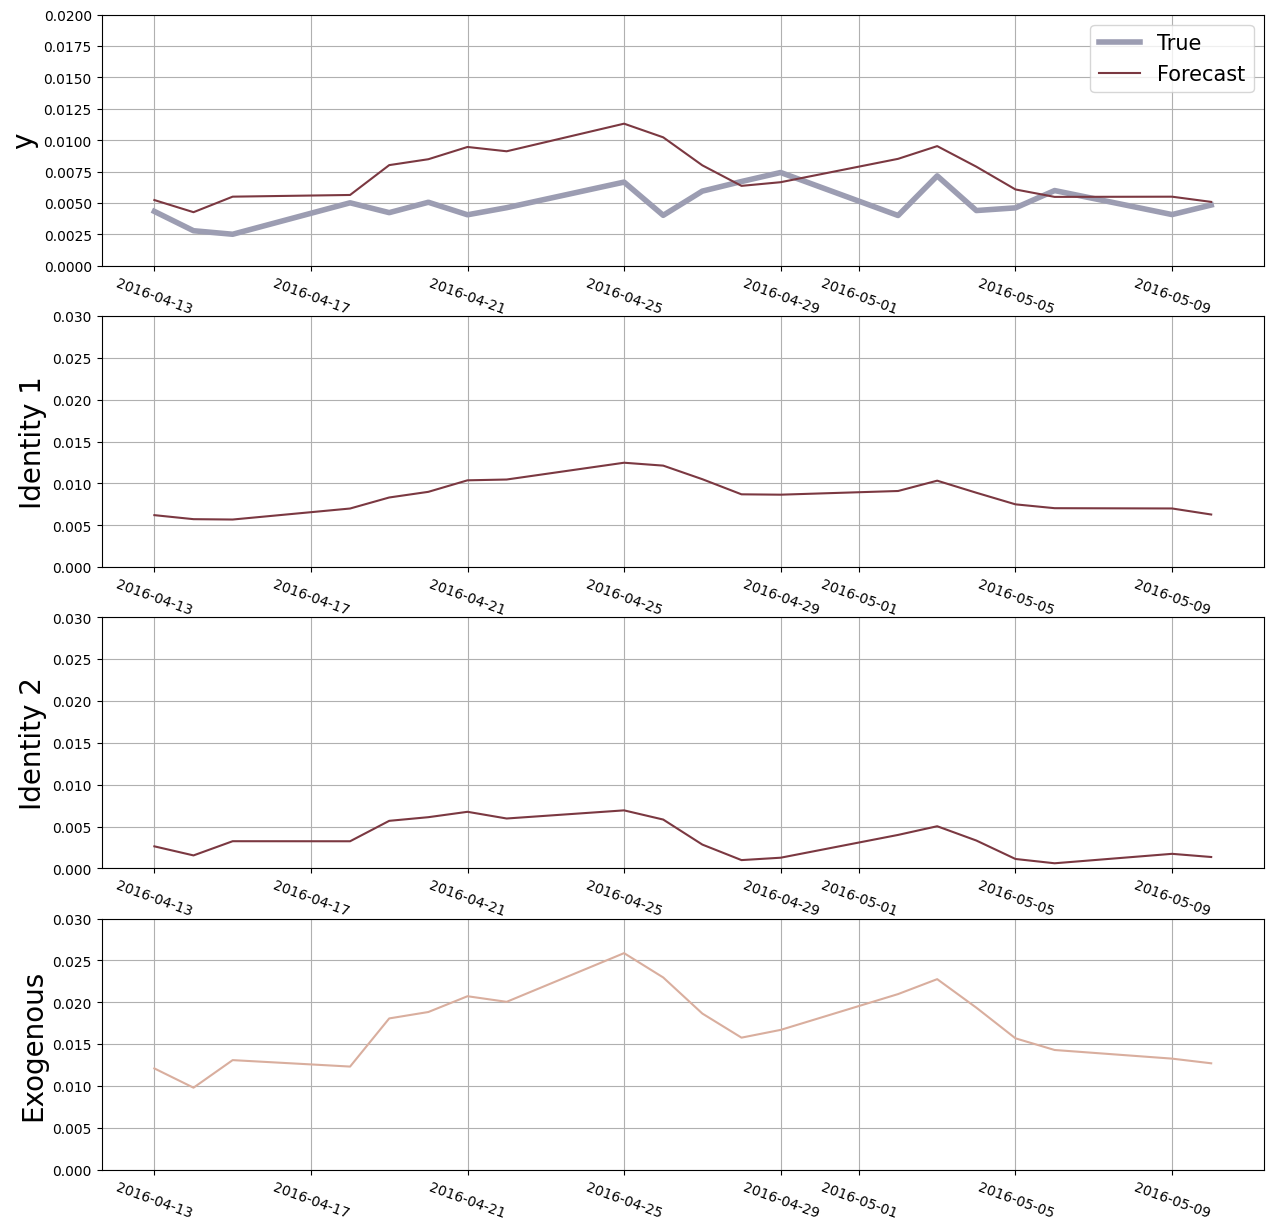

In [47]:
fig, ax = plt.subplots(4, 1, figsize=(15, 15))

ax[0].plot(test['ds'][:20],test['y'][:20].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(test['ds'][:20],y_hat.sum(axis=1).flatten()/3, label='Forecast', color="#7B3841")
ax[0].grid()
ax[0].tick_params(axis="x", rotation=-20)
ax[0].legend(prop={'size': 15})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(10)
ax[0].set_ylabel('y', fontsize=20)
ax[0].set_ylim((0,0.020))

ax[1].plot(test['ds'][:20],y_hat[:,0], label='level', color="#7B3841")
ax[1].grid()
ax[1].set_ylabel('Identity 1', fontsize=20)
ax[1].set_ylim((0,0.03))
ax[1].tick_params(axis="x", rotation=-20)

ax[2].plot(test['ds'][:20],y_hat[:,1], label='stack1', color="#7B3841")
ax[2].grid()
ax[2].set_ylabel('Identity 2', fontsize=20)
ax[2].set_ylim((0,0.03))
ax[2].tick_params(axis="x", rotation=-20)

ax[3].plot(test['ds'][:20],y_hat[:,2], label='stack2', color="#D9AE9E")
ax[3].grid()
ax[3].set_ylabel('Exogenous', fontsize=20)
ax[3].set_ylim((0,0.03))
ax[3].tick_params(axis="x", rotation=-20)